# Analyse Hyperparameter Tuning (Optuna DB)

Dieses Notebook liest eine oder mehrere Optuna SQLite-Datenbanken und liefert:
1. **Uebersicht** — Anzahl Trials, Status-Verteilung, Dauer
2. **Trial-Zusammenfassungen & Ranking**
3. **Beste Parameter** — Copy-paste-ready Konfigurationen
4. **Problemanalyse** — NaN, FAIL, PRUNED mit Ursachendiagnose
5. **Optuna-Visualisierungen** — Alle 9 Standard-Plots + Multi-Study-Vergleich
6. **Epoch-Level-Analyse** — Per-Epoch Lernkurven, Per-Class F1, Confusion Matrices (neues DB-Format)
7. **Custom-Visualisierungen** — Korrelationen, Scatter, Box-Plots, Fold-Heatmap
8. **Phase-2-Suchbereiche** — Empfohlene Parameter-Ranges

---
**Nutzung:** Nur die erste Code-Zelle (`KONFIGURATION`) anpassen, dann alle Zellen ausfuehren.

In [15]:
# ============================================================
# KONFIGURATION — Hier anpassen
# ============================================================
from pathlib import Path

# DB_PATHS: Eine oder mehrere Datenbanken (relativ zum Notebook oder absolut)
DB_PATHS = [
    "../performance_reports/hpt_eurobert_210m_phase1.db",
]

# Optional: Display-Namen fuer die Studies (None = automatisch aus DB)
STUDY_DISPLAY_NAMES = None  # z.B. ["Phase 1", "Phase 2"]

TOP_N = 5           # Anzahl Top-Trials fuer Detail-Analyse
SAVE_PLOTS = False  # True = Plots als PNG speichern

# --- Auto-Resolve Paths ---
_resolved = []
for _p_str in DB_PATHS:
    _p = Path(_p_str)
    if not _p.exists():
        for _base in [Path("../performance_reports"),
                      Path("Python/classification_pipeline/performance_reports"),
                      Path("performance_reports")]:
            _candidate = _base / _p.name
            if _candidate.exists():
                _p = _candidate
                break
    if not _p.exists():
        print(f"WARNING: DB nicht gefunden: {_p_str}")
    else:
        _resolved.append(str(_p.resolve()))

DB_PATHS = _resolved
print(f"{len(DB_PATHS)} Datenbank(en) geladen:")
for _p in DB_PATHS:
    print(f"  {_p}")

1 Datenbank(en) geladen:
  /Users/zorbeyozcan/news_articles_classification_thesis/Python/classification_pipeline/performance_reports/hpt_eurobert_210m_phase1.db


In [16]:
# ============================================================
# Imports und Setup
# ============================================================
import sqlite3
import json
import warnings
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch

import optuna
from optuna.importance import FanovaImportanceEvaluator
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour,
    plot_intermediate_values,
    plot_rank,
    plot_timeline,
    plot_edf,
)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.float_format", lambda x: f"{x:.6g}")

plt.rcParams.update({
    "figure.figsize": (14, 6),
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "figure.dpi": 100,
})

In [17]:
# ============================================================
# Hilfsfunktionen
# ============================================================

def load_studies(db_paths, display_names=None):
    """Load Optuna studies from multiple DB files via Optuna API."""
    studies = []
    for i, db_path in enumerate(db_paths):
        storage_url = f"sqlite:///{db_path}"
        summaries = optuna.study.get_all_study_summaries(storage=storage_url)
        if not summaries:
            print(f"  WARNING: Keine Studies in {db_path}")
            continue
        summary = summaries[0]
        study = optuna.load_study(study_name=summary.study_name, storage=storage_url)
        name = display_names[i] if display_names and i < len(display_names) else summary.study_name
        studies.append({
            "study": study,
            "name": name,
            "db_path": db_path,
            "storage_url": storage_url,
        })
        print(f"  Geladen: {name} ({len(study.trials)} trials)")
    return studies


def load_raw_data(db_path):
    """Load raw trial data via sqlite3 for custom analysis."""
    conn = sqlite3.connect(db_path)

    studies_df = pd.read_sql("SELECT * FROM studies", conn)
    study_id = int(studies_df.iloc[0]["study_id"])

    direction_row = pd.read_sql(
        f"SELECT direction FROM study_directions WHERE study_id = {study_id}", conn
    ).iloc[0]
    direction = direction_row["direction"]
    ascending = direction == "MINIMIZE"

    trials = pd.read_sql(f"SELECT * FROM trials WHERE study_id = {study_id}", conn)
    trials["datetime_start"] = pd.to_datetime(trials["datetime_start"])
    trials["datetime_complete"] = pd.to_datetime(trials["datetime_complete"])
    trials["duration_min"] = (
        (trials["datetime_complete"] - trials["datetime_start"]).dt.total_seconds() / 60
    )

    values = pd.read_sql("SELECT * FROM trial_values", conn)
    params_raw = pd.read_sql("SELECT * FROM trial_params", conn)
    intermediates = pd.read_sql("SELECT * FROM trial_intermediate_values", conn)

    # User attributes (may not exist in old DBs)
    try:
        user_attrs = pd.read_sql("SELECT * FROM trial_user_attributes", conn)
    except Exception:
        user_attrs = pd.DataFrame()

    conn.close()

    # Decode parameters
    def decode_param(row):
        dist = json.loads(row["distribution_json"])
        if dist["name"] == "CategoricalDistribution":
            choices = dist["attributes"]["choices"]
            idx = int(row["param_value"])
            return choices[idx]
        if dist["name"] == "IntDistribution":
            return int(row["param_value"])
        return row["param_value"]

    if len(params_raw) > 0:
        params_raw["decoded_value"] = params_raw.apply(decode_param, axis=1)

        param_distributions = {}
        for _, row in params_raw.drop_duplicates("param_name").iterrows():
            dist = json.loads(row["distribution_json"])
            param_distributions[row["param_name"]] = dist

        params_pivot = params_raw.pivot(
            index="trial_id", columns="param_name", values="decoded_value"
        ).reset_index()

        df = trials.merge(values[["trial_id", "value", "value_type"]], on="trial_id", how="left")
        df = df.merge(params_pivot, on="trial_id", how="left")
        param_names = sorted(params_pivot.columns.drop("trial_id").tolist())
    else:
        df = trials.merge(values[["trial_id", "value", "value_type"]], on="trial_id", how="left")
        param_distributions = {}
        param_names = []

    df = df.sort_values("number").reset_index(drop=True)

    return {
        "df": df,
        "param_names": param_names,
        "param_distributions": param_distributions,
        "intermediates": intermediates,
        "user_attrs": user_attrs,
        "direction": direction,
        "ascending": ascending,
    }


def load_rich_metrics(study):
    """Load per-epoch/fold rich metrics from trial user_attrs (neues Format von hpt_utils)."""
    rich_data = []
    has_rich = False
    for trial in study.trials:
        attrs = trial.user_attrs
        summary = None
        if "trial_summary" in attrs:
            has_rich = True
            summary_raw = attrs["trial_summary"]
            summary = json.loads(summary_raw) if isinstance(summary_raw, str) else summary_raw

        fold_metrics = []
        for key in sorted(attrs.keys()):
            if key.startswith("fold_") and key.endswith("_metrics"):
                val = attrs[key]
                parsed = json.loads(val) if isinstance(val, str) else val
                fold_metrics.append(parsed)

        rich_data.append({
            "trial_number": trial.number,
            "value": trial.value,
            "state": str(trial.state),
            "trial_summary": summary,
            "fold_metrics": fold_metrics,
            "nan_trial": attrs.get("nan_trial", False),
        })
    return rich_data, has_rich

In [18]:
# ============================================================
# Alle Studies laden
# ============================================================
all_studies = load_studies(DB_PATHS, STUDY_DISPLAY_NAMES)
all_raw = {s["name"]: load_raw_data(s["db_path"]) for s in all_studies}

print(f"\n{'=' * 70}")
print(f"  {len(all_studies)} Study/Studies geladen")
print(f"{'=' * 70}")

  Geladen: eurobert_210m_hpt_phase1 (19 trials)

  1 Study/Studies geladen


---
## 1. Uebersicht

In [19]:
# ============================================================
# 1. UEBERSICHT
# ============================================================

for entry in all_studies:
    name = entry["name"]
    raw = all_raw[name]
    df = raw["df"]
    ascending = raw["ascending"]
    param_distributions = raw["param_distributions"]

    print(f"\n{'=' * 70}")
    print(f"  STUDY: {name}")
    print(f"{'=' * 70}")

    # Status
    state_counts = df["state"].value_counts()
    print(f"\nTotal Trials: {len(df)}")
    for state, count in state_counts.items():
        print(f"  {state:12s}: {count}")

    # Dauer
    completed_mask = df["duration_min"].notna()
    if completed_mask.any():
        dur = df.loc[completed_mask, "duration_min"]
        print(f"\nDauer (Min):")
        print(f"  Min:    {dur.min():.1f}")
        print(f"  Max:    {dur.max():.1f}")
        print(f"  Mean:   {dur.mean():.1f}")
        print(f"  Total:  {dur.sum():.0f} min ({dur.sum()/60:.1f} h)")

    # Metrik
    valid = df[(df["state"] == "COMPLETE") & (df["value"].notna())]
    if len(valid) > 0:
        print(f"\nZielmetrik (nur COMPLETE):")
        print(f"  Min:    {valid['value'].min():.6f}")
        print(f"  Max:    {valid['value'].max():.6f}")
        print(f"  Mean:   {valid['value'].mean():.6f}")
        print(f"  Std:    {valid['value'].std():.6f}")

    # Suchbereiche
    if param_distributions:
        print(f"\nParameter-Suchbereiche:")
        for pname, dist in sorted(param_distributions.items()):
            attrs = dist["attributes"]
            dtype = dist["name"]
            if dtype == "CategoricalDistribution":
                print(f"  {pname:30s}: {attrs['choices']}")
            elif dtype == "IntDistribution":
                print(f"  {pname:30s}: [{attrs['low']}, {attrs['high']}] (int)")
            else:
                log_str = " (log)" if attrs.get("log") else ""
                print(f"  {pname:30s}: [{attrs['low']}, {attrs['high']}]{log_str}")


  STUDY: eurobert_210m_hpt_phase1

Total Trials: 19
  COMPLETE    : 14
  RUNNING     : 2
  PRUNED      : 2
  FAIL        : 1

Dauer (Min):
  Min:    8.1
  Max:    67.0
  Mean:   37.1
  Total:  631 min (10.5 h)

Zielmetrik (nur COMPLETE):
  Min:    0.529162
  Max:    0.839348
  Mean:   0.704999
  Std:    0.139278

Parameter-Suchbereiche:
  classifier_dropout            : [0.0, 0.5]
  label_smoothing_factor        : [0.0, 0.1]
  learning_rate                 : [1e-05, 5e-05] (log)
  lr_scheduler_type             : ['linear', 'cosine']
  num_train_epochs              : [5, 15] (int)
  per_device_train_batch_size   : [4, 8]
  warmup_ratio                  : [0.0, 0.15]
  weight_decay                  : [0.0, 0.1]


---
## 2. Trial-Zusammenfassungen & Ranking

In [20]:
# ============================================================
# 2. TRIAL-ZUSAMMENFASSUNGEN & RANKING
# ============================================================

for entry in all_studies:
    name = entry["name"]
    raw = all_raw[name]
    df = raw["df"]
    param_names = raw["param_names"]
    ascending = raw["ascending"]
    intermediates = raw["intermediates"]

    display_cols = ["number", "state", "value", "duration_min"] + param_names

    print(f"\n{'=' * 70}")
    print(f"  {name} — ALLE TRIALS")
    print(f"{'=' * 70}\n")
    print(df[display_cols].to_string(index=False))

    # Detail pro Trial (Fold-Ergebnisse)
    print(f"\n{'=' * 70}")
    print(f"  {name} — DETAIL PRO TRIAL")
    print(f"{'=' * 70}")

    for _, row in df.iterrows():
        trial_num = int(row["number"])
        state = row["state"]
        value = row["value"]
        dur = row["duration_min"]
        trial_ints = intermediates[intermediates["trial_id"] == row["trial_id"]].sort_values("step")

        print(f"\n--- Trial #{trial_num} [{state}] ---")
        if pd.notna(value):
            print(f"  Zielmetrik (CV Mean): {value:.6f}")
        else:
            print(f"  Zielmetrik: KEIN WERT")
        if pd.notna(dur):
            print(f"  Dauer: {dur:.1f} min")

        if len(trial_ints) > 0:
            fold_vals = trial_ints["intermediate_value"].values
            print(f"  Fold-Ergebnisse: {['%.6f' % v for v in fold_vals]}")
            if len(fold_vals) > 1:
                std = np.std(fold_vals)
                spread = max(fold_vals) - min(fold_vals)
                print(f"  Fold-Std: {std:.6f}  |  Spread: {spread:.6f}")

    # Ranking
    ranked = df[df["value"].notna()].sort_values("value", ascending=ascending).reset_index(drop=True)
    ranked.index = ranked.index + 1
    ranked.index.name = "Rang"

    direction_str = raw["direction"]
    print(f"\n{'=' * 70}")
    print(f"  {name} — RANKING ({direction_str})")
    print(f"{'=' * 70}\n")
    print(ranked[display_cols].to_string())


  eurobert_210m_hpt_phase1 — ALLE TRIALS

 number    state     value  duration_min classifier_dropout label_smoothing_factor learning_rate lr_scheduler_type num_train_epochs per_device_train_batch_size warmup_ratio weight_decay
      0 COMPLETE  0.551231       34.6195          0.0290418              0.0598658   1.82723e-05            linear               12                           4     0.109799    0.0950714
      1 COMPLETE  0.529162       26.1588           0.152121              0.0212339   1.03368e-05            cosine                8                           4     0.124866     0.096991
      2 COMPLETE  0.801921       22.1694          0.0998369              0.0366362   2.67711e-05            cosine                5                           8    0.0438217    0.0139494
      3 COMPLETE  0.548253       31.5048           0.152307              0.0948886   2.65862e-05            linear                9                           8   0.00975774    0.0170524
      4 COMPLETE   0.78814 

---
## 3. Beste Parameter (Copy-Paste-Ready)

In [21]:
# ============================================================
# 3. BESTE PARAMETER — Kanonische Extraktion
# ============================================================

for entry in all_studies:
    name = entry["name"]
    raw = all_raw[name]
    df = raw["df"]
    param_names = raw["param_names"]
    ascending = raw["ascending"]

    completed = df[df["state"] == "COMPLETE"].sort_values("value", ascending=ascending)
    top_n = completed.head(TOP_N)

    print(f"\n{'=' * 70}")
    print(f"  {name} — TOP {TOP_N} TRIALS")
    print(f"{'=' * 70}\n")

    for rank, (_, row) in enumerate(top_n.iterrows(), 1):
        print(f"  #{rank}  Trial {int(row['number']):2d}  |  Metrik: {row['value']:.6f}  |  Dauer: {row['duration_min']:.1f} min")

    # Parameter-Bereiche der Top-N
    print(f"\n  PARAMETER-BEREICHE DER TOP {TOP_N}:")
    print(f"  {'-' * 60}")
    for p in param_names:
        vals = top_n[p]
        numeric = pd.to_numeric(vals, errors="coerce")
        if numeric.notna().all():
            print(f"  {p:30s}: min={numeric.min():.6g}  max={numeric.max():.6g}  mean={numeric.mean():.6g}")
        else:
            print(f"  {p:30s}: {vals.value_counts().to_dict()}")

    # Bester Trial — Copy-Paste-Ready
    best = top_n.iloc[0]
    print(f"\n{'=' * 70}")
    print(f"  BESTER TRIAL: #{int(best['number'])}  |  Metrik: {best['value']:.6f}")
    print(f"{'=' * 70}")
    print(f"\n  Copy-paste-ready Parameter:")
    print(f"  {'-' * 60}")
    for p in param_names:
        val = best[p]
        if isinstance(val, float):
            if "learning_rate" in p:
                print(f'  "{p}": {val:.2e},')
            elif val == int(val):
                print(f'  "{p}": {int(val)},')
            else:
                print(f'  "{p}": {val:.6g},')
        else:
            print(f'  "{p}": "{val}",')

    # Top-N vs. Bottom-N Vergleich
    bottom_n = completed.tail(TOP_N)
    print(f"\n  PARAMETER-VERGLEICH: Top {TOP_N} vs. Bottom {TOP_N}")
    print(f"  {'-' * 60}")

    for p in param_names:
        top_vals = pd.to_numeric(top_n[p], errors="coerce")
        bot_vals = pd.to_numeric(bottom_n[p], errors="coerce")
        if top_vals.notna().all() and bot_vals.notna().all():
            diff_pct = ((top_vals.mean() - bot_vals.mean()) / bot_vals.mean() * 100) if bot_vals.mean() != 0 else 0
            flag = " <--" if abs(diff_pct) > 30 else ""
            print(f"  {p:30s}: Top={top_vals.mean():.6g}  Bot={bot_vals.mean():.6g}  ({diff_pct:+.1f}%){flag}")
        else:
            top_mode = top_n[p].mode().iloc[0] if len(top_n[p].mode()) > 0 else "N/A"
            bot_mode = bottom_n[p].mode().iloc[0] if len(bottom_n[p].mode()) > 0 else "N/A"
            print(f"  {p:30s}: Top=mode({top_mode})  Bot=mode({bot_mode})")


  eurobert_210m_hpt_phase1 — TOP 5 TRIALS

  #1  Trial 11  |  Metrik: 0.839348  |  Dauer: 54.5 min
  #2  Trial 14  |  Metrik: 0.837066  |  Dauer: 62.0 min
  #3  Trial  7  |  Metrik: 0.829509  |  Dauer: 67.0 min
  #4  Trial  9  |  Metrik: 0.827204  |  Dauer: 51.9 min
  #5  Trial 12  |  Metrik: 0.825300  |  Dauer: 54.6 min

  PARAMETER-BEREICHE DER TOP 5:
  ------------------------------------------------------------
  classifier_dropout            : min=0.263889  max=0.395418  mean=0.334411
  label_smoothing_factor        : min=0.0227139  max=0.0671269  mean=0.0481013
  learning_rate                 : min=3.70582e-05  max=4.99121e-05  mean=4.43204e-05
  lr_scheduler_type             : {'linear': 4, 'cosine': 1}
  num_train_epochs              : min=13  max=15  mean=14.2
  per_device_train_batch_size   : min=4  max=8  mean=4.8
  warmup_ratio                  : min=0.0826976  max=0.145431  mean=0.0980836
  weight_decay                  : min=0.0289385  max=0.0706134  mean=0.0469948

  BE

---
## 4. Problemanalyse

In [22]:
# ============================================================
# 4. PROBLEMANALYSE — NaN, FAIL, PRUNED, niedrige Scores
# ============================================================

for entry in all_studies:
    name = entry["name"]
    raw = all_raw[name]
    df = raw["df"]
    param_names = raw["param_names"]
    param_distributions = raw["param_distributions"]
    intermediates = raw["intermediates"]

    # Problematische Trials identifizieren
    problem_mask = (
        (df["state"] != "COMPLETE") |
        (df["value"].isna()) |
        (df["value"] < 0.5)
    )
    problems = df[problem_mask].copy()

    print(f"\n{'=' * 70}")
    print(f"  {name} — PROBLEMANALYSE")
    print(f"{'=' * 70}")
    print(f"\nProblematische Trials: {len(problems)} von {len(df)}")

    if len(problems) == 0:
        print("  Keine problematischen Trials gefunden!")
        continue

    for _, row in problems.iterrows():
        trial_num = int(row["number"])
        state = row["state"]
        value = row["value"]
        trial_ints = intermediates[intermediates["trial_id"] == row["trial_id"]].sort_values("step")

        print(f"\n{'─' * 60}")
        print(f"  Trial #{trial_num}  |  Status: {state}  |  Metrik: {value if pd.notna(value) else 'KEIN WERT'}")
        print(f"{'─' * 60}")

        if len(trial_ints) > 0:
            fold_vals = trial_ints["intermediate_value"].values
            print(f"  Fold-Ergebnisse:")
            for _, iv in trial_ints.iterrows():
                v = iv["intermediate_value"]
                flag = " <-- NEAR ZERO!" if v < 0.05 else (" <-- NIEDRIG" if v < 0.5 else "")
                print(f"    Fold {int(iv['step'])}: {v:.6f}{flag}")

        # Diagnose
        reasons = []
        lr = pd.to_numeric(row.get("learning_rate"), errors="coerce") if "learning_rate" in row.index else np.nan
        wd = pd.to_numeric(row.get("weight_decay"), errors="coerce") if "weight_decay" in row.index else np.nan
        cd = pd.to_numeric(row.get("classifier_dropout"), errors="coerce") if "classifier_dropout" in row.index else np.nan
        warmup = pd.to_numeric(row.get("warmup_ratio"), errors="coerce") if "warmup_ratio" in row.index else np.nan

        if pd.notna(cd) and cd > 0.4:
            reasons.append(f"Sehr hoher classifier_dropout ({cd:.3f})")
        if pd.notna(lr) and lr < 1.5e-5:
            reasons.append(f"Niedrige learning_rate ({lr:.2e})")
        if pd.notna(wd) and wd > 0.08:
            reasons.append(f"Hoher weight_decay ({wd:.4f})")
        if pd.notna(warmup) and warmup > 0.12:
            reasons.append(f"Hohe warmup_ratio ({warmup:.4f})")
        if pd.notna(cd) and cd > 0.3 and pd.notna(wd) and wd > 0.05:
            reasons.append("Kombination Dropout + Weight Decay (doppelte Regularisierung)")

        if len(trial_ints) > 0:
            fold_vals = trial_ints["intermediate_value"].values
            if fold_vals[0] < 0.05 and len(fold_vals) >= 2 and fold_vals[1] < 0.05:
                reasons.append("Konsistent near-zero ueber Folds (systematisch)")
            if fold_vals[0] < 0.05 and len(fold_vals) >= 2 and fold_vals[1] > 0.3:
                reasons.append("Erster Fold near-zero, spaetere besser (numerische Instabilitaet)")

        if state == "FAIL":
            reasons.append("Trial FAIL: wahrscheinlich NaN in Gradienten")
        if state == "RUNNING":
            reasons.append("RUNNING ohne Ergebnis: Session vermutlich abgebrochen")

        if reasons:
            print(f"  Diagnose:")
            for r in reasons:
                print(f"    -> {r}")

    # Schlussfolgerungen
    good_trials = df[(df["state"] == "COMPLETE") & (df["value"] > 0.7)]
    bad_trials = df[(df["state"] == "COMPLETE") & (df["value"] < 0.6)]
    conclusions = []

    if len(good_trials) > 0 and len(bad_trials) > 0:
        good_lr = pd.to_numeric(good_trials.get("learning_rate", pd.Series(dtype=float)), errors="coerce").mean()
        bad_lr = pd.to_numeric(bad_trials.get("learning_rate", pd.Series(dtype=float)), errors="coerce").mean()
        if pd.notna(good_lr) and pd.notna(bad_lr) and bad_lr > 0:
            if good_lr > bad_lr * 1.5:
                conclusions.append(f"Hoehere LR performen besser (gut: {good_lr:.2e} vs schlecht: {bad_lr:.2e})")

        good_ep = pd.to_numeric(good_trials.get("num_train_epochs", pd.Series(dtype=float)), errors="coerce").mean()
        bad_ep = pd.to_numeric(bad_trials.get("num_train_epochs", pd.Series(dtype=float)), errors="coerce").mean()
        if pd.notna(good_ep) and pd.notna(bad_ep) and bad_ep > 0:
            if good_ep > bad_ep * 1.3:
                conclusions.append(f"Mehr Epochs helfen (gut: {good_ep:.0f} vs schlecht: {bad_ep:.0f})")

    if len(good_trials) > 0 and "per_device_train_batch_size" in good_trials.columns:
        good_bs = good_trials["per_device_train_batch_size"].value_counts()
        if len(good_bs) > 0:
            dominant_bs = good_bs.index[0]
            pct = good_bs.iloc[0] / len(good_trials) * 100
            if pct >= 70:
                conclusions.append(f"Batch Size {dominant_bs} dominiert bei guten Trials ({pct:.0f}%)")

    if conclusions:
        print(f"\n  SCHLUSSFOLGERUNGEN:")
        for i, c in enumerate(conclusions, 1):
            print(f"    {i}. {c}")


  eurobert_210m_hpt_phase1 — PROBLEMANALYSE

Problematische Trials: 5 von 19

────────────────────────────────────────────────────────────
  Trial #8  |  Status: RUNNING  |  Metrik: KEIN WERT
────────────────────────────────────────────────────────────
  Diagnose:
    -> Kombination Dropout + Weight Decay (doppelte Regularisierung)
    -> RUNNING ohne Ergebnis: Session vermutlich abgebrochen

────────────────────────────────────────────────────────────
  Trial #10  |  Status: PRUNED  |  Metrik: 0.012256093712905057
────────────────────────────────────────────────────────────
  Fold-Ergebnisse:
    Fold 0: 0.012248 <-- NEAR ZERO!
    Fold 1: 0.012256 <-- NEAR ZERO!
  Diagnose:
    -> Sehr hoher classifier_dropout (0.495)
    -> Kombination Dropout + Weight Decay (doppelte Regularisierung)
    -> Konsistent near-zero ueber Folds (systematisch)

────────────────────────────────────────────────────────────
  Trial #15  |  Status: RUNNING  |  Metrik: KEIN WERT
─────────────────────────────

---
## 5. Optuna-Visualisierungen

In [23]:
# ============================================================
# 5a. OPTUNA-VISUALISIERUNGEN (Single-Study)
# ============================================================

for entry in all_studies:
    study = entry["study"]
    name = entry["name"]

    print(f"\n{'=' * 70}")
    print(f"  {name} — Optuna-Plots")
    print(f"{'=' * 70}")

    # --- Determine parameter names for pairwise plots ---
    param_names_optuna = list(study.best_trial.params.keys()) if study.best_trial else []

    # 1. Optimization History
    try:
        fig = plot_optimization_history(study)
        fig.update_layout(title=f"{name} — Optimization History")
        fig.show()
    except Exception as e:
        print(f"  plot_optimization_history: {e}")

    # 2. Parameter Importances (default evaluator)
    try:
        fig = plot_param_importances(study)
        fig.update_layout(title=f"{name} — Parameter Importances")
        fig.show()
    except Exception as e:
        print(f"  plot_param_importances: {e}")

    # 3. Parameter Importances with FANOVA (interaction terms)
    try:
        fanova_evaluator = FanovaImportanceEvaluator()
        importances = optuna.importance.get_param_importances(study, evaluator=fanova_evaluator)
        fig = plot_param_importances(study, evaluator=fanova_evaluator)
        fig.update_layout(title=f"{name} — Parameter Importances (FANOVA)")
        fig.show()

        # Interaction importance: evaluate all pairs
        print(f"\n  FANOVA Interaction Analysis:")
        print(f"  {'Parameter Pair':50s}  {'Interaction Importance':>22s}")
        print(f"  {'-' * 75}")

        if len(param_names_optuna) >= 2:
            pair_importances = {}
            for p1, p2 in combinations(param_names_optuna, 2):
                try:
                    # Importance of pair together vs individual
                    imp_p1 = importances.get(p1, 0)
                    imp_p2 = importances.get(p2, 0)
                    # Use a sub-study approach: evaluate with only these 2 params
                    pair_eval = FanovaImportanceEvaluator()
                    pair_imp = optuna.importance.get_param_importances(
                        study, evaluator=pair_eval, params=[p1, p2]
                    )
                    total_pair = sum(pair_imp.values())
                    individual_sum = imp_p1 + imp_p2
                    # Interaction = how much the pair explains beyond individual effects
                    interaction = max(0, total_pair - individual_sum)
                    pair_importances[(p1, p2)] = interaction
                except Exception:
                    pass

            # Sort by interaction strength
            for (p1, p2), imp in sorted(pair_importances.items(), key=lambda x: x[1], reverse=True):
                if imp > 0.001:
                    print(f"  {p1} x {p2:30s}  {imp:>22.4f}")

            if not any(v > 0.001 for v in pair_importances.values()):
                print(f"  Keine signifikanten Interaktionen gefunden.")
    except Exception as e:
        print(f"  FANOVA interaction analysis: {e}")

    # 4. Parallel Coordinate
    try:
        fig = plot_parallel_coordinate(study)
        fig.update_layout(title=f"{name} — Parallel Coordinate")
        fig.show()
    except Exception as e:
        print(f"  plot_parallel_coordinate: {e}")

    # 5. Slice Plot
    try:
        fig = plot_slice(study)
        fig.update_layout(title=f"{name} — Slice Plot")
        fig.show()
    except Exception as e:
        print(f"  plot_slice: {e}")

    # 6. Contour Plots — Individual pairwise (top pairs by importance)
    try:
        # Get top parameters by importance for readable pairwise plots
        imp = optuna.importance.get_param_importances(study)
        sorted_params = [p for p in sorted(imp, key=imp.get, reverse=True) if p in param_names_optuna]
        # Take top 4 most important params, generate all pairs
        top_params = sorted_params[:4]

        if len(top_params) >= 2:
            pairs = list(combinations(top_params, 2))
            print(f"\n  Contour Plots: {len(pairs)} Paare der Top-{len(top_params)} wichtigsten Parameter")

            for p1, p2 in pairs:
                try:
                    fig = plot_contour(study, params=[p1, p2])
                    fig.update_layout(
                        title=f"{name} — Contour: {p1} vs {p2}",
                        width=700,
                        height=550,
                    )
                    fig.show()
                except Exception as e:
                    print(f"    Contour {p1} vs {p2}: {e}")
        else:
            print("  Contour: Weniger als 2 Parameter, uebersprungen.")
    except Exception as e:
        print(f"  Contour plots: {e}")

    # 7. Intermediate Values (Fold-Level)
    try:
        fig = plot_intermediate_values(study)
        fig.update_layout(title=f"{name} — Intermediate Values (Folds)")
        fig.show()
    except Exception as e:
        print(f"  plot_intermediate_values: {e}")

    # 8. Rank Plots — Individual pairwise (top pairs by importance)
    try:
        if len(top_params) >= 2:
            print(f"\n  Rank Plots: {len(pairs)} Paare der Top-{len(top_params)} wichtigsten Parameter")

            for p1, p2 in pairs:
                try:
                    fig = plot_rank(study, params=[p1, p2])
                    fig.update_layout(
                        title=f"{name} — Rank: {p1} vs {p2}",
                        width=700,
                        height=550,
                    )
                    fig.show()
                except Exception as e:
                    print(f"    Rank {p1} vs {p2}: {e}")
        else:
            print("  Rank: Weniger als 2 Parameter, uebersprungen.")
    except Exception as e:
        print(f"  Rank plots: {e}")

    # 9. Timeline
    try:
        fig = plot_timeline(study)
        fig.update_layout(title=f"{name} — Timeline")
        fig.show()
    except Exception as e:
        print(f"  plot_timeline: {e}")

    # 10. EDF (Empirical Distribution Function)
    try:
        fig = plot_edf(study)
        fig.update_layout(title=f"{name} — EDF")
        fig.show()
    except Exception as e:
        print(f"  plot_edf: {e}")


  eurobert_210m_hpt_phase1 — Optuna-Plots



  FANOVA Interaction Analysis:
  Parameter Pair                                      Interaction Importance
  ---------------------------------------------------------------------------
  lr_scheduler_type x per_device_train_batch_size                     0.9674
  label_smoothing_factor x per_device_train_batch_size                     0.9014
  label_smoothing_factor x lr_scheduler_type                               0.8937
  classifier_dropout x per_device_train_batch_size                     0.8472
  lr_scheduler_type x classifier_dropout                              0.8396
  per_device_train_batch_size x num_train_epochs                                0.8191
  warmup_ratio x per_device_train_batch_size                     0.8138
  lr_scheduler_type x num_train_epochs                                0.8114
  warmup_ratio x lr_scheduler_type                               0.8061
  weight_decay x per_device_train_batch_size                     0.7928
  weight_decay x lr_scheduler_type   


  Contour Plots: 6 Paare der Top-4 wichtigsten Parameter



  Rank Plots: 6 Paare der Top-4 wichtigsten Parameter


In [24]:
# ============================================================
# 5b. MULTI-STUDY-VERGLEICH (nur wenn >1 DB geladen)
# ============================================================

if len(all_studies) > 1:
    print(f"{'=' * 70}")
    print(f"  MULTI-STUDY-VERGLEICH")
    print(f"{'=' * 70}")

    # 1. EDF Comparison (native Optuna multi-study)
    try:
        optuna_studies = [e["study"] for e in all_studies]
        study_names = [e["name"] for e in all_studies]
        fig = plot_edf(optuna_studies, target_name="F1 Macro")
        fig.update_layout(title="Multi-Study EDF Comparison")
        fig.show()
    except Exception as e:
        print(f"  Multi-study EDF: {e}")

    # 2. Optimization History Overlay
    fig, ax = plt.subplots(figsize=(14, 6))
    for entry in all_studies:
        raw = all_raw[entry["name"]]
        df = raw["df"]
        ascending = raw["ascending"]
        valid = df[df["value"].notna()].sort_values("number")
        if len(valid) == 0:
            continue
        cum_best = valid["value"].cummin() if ascending else valid["value"].cummax()
        ax.plot(valid["number"], cum_best, "o-", label=entry["name"], markersize=5)
    ax.set_xlabel("Trial #")
    ax.set_ylabel("Kumulativ beste Metrik")
    ax.set_title("Optimization History — Vergleich")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # 3. Best Parameters Side-by-Side
    print(f"\n  BESTE PARAMETER IM VERGLEICH:")
    print(f"  {'Parameter':30s}", end="")
    for entry in all_studies:
        print(f"  {entry['name']:>20s}", end="")
    print()
    print(f"  {'-' * (30 + 22 * len(all_studies))}")

    all_param_names = set()
    for entry in all_studies:
        all_param_names.update(all_raw[entry["name"]]["param_names"])

    for p in sorted(all_param_names):
        print(f"  {p:30s}", end="")
        for entry in all_studies:
            raw = all_raw[entry["name"]]
            df = raw["df"]
            ascending = raw["ascending"]
            completed = df[df["state"] == "COMPLETE"].sort_values("value", ascending=ascending)
            if len(completed) > 0 and p in completed.columns:
                best = completed.iloc[0]
                val = best[p]
                if isinstance(val, float):
                    print(f"  {val:>20.6g}", end="")
                else:
                    print(f"  {str(val):>20s}", end="")
            else:
                print(f"  {'N/A':>20s}", end="")
        print()

    # 4. Per-Class F1 Comparison (if rich metrics available)
    has_any_rich = False
    for entry in all_studies:
        _, has_rich = load_rich_metrics(entry["study"])
        if has_rich:
            has_any_rich = True

    if has_any_rich:
        fig, ax = plt.subplots(figsize=(16, 6))
        x_offset = 0
        bar_width = 0.8 / len(all_studies)

        class_names = None
        for i, entry in enumerate(all_studies):
            rich_data, has_rich = load_rich_metrics(entry["study"])
            if not has_rich:
                continue
            # Find best trial
            best_rd = max(
                [rd for rd in rich_data if rd["trial_summary"] is not None],
                key=lambda rd: rd["trial_summary"].get("mean_f1_macro", 0),
                default=None,
            )
            if best_rd is None:
                continue
            mean_pc = best_rd["trial_summary"].get("mean_per_class", {})
            if not mean_pc:
                continue
            if class_names is None:
                class_names = sorted(mean_pc.keys())
            f1_vals = [mean_pc.get(c, {}).get("f1", 0) for c in class_names]
            x = np.arange(len(class_names)) + i * bar_width
            ax.bar(x, f1_vals, bar_width, label=entry["name"], alpha=0.8)

        if class_names is not None:
            ax.set_xticks(np.arange(len(class_names)) + bar_width * (len(all_studies) - 1) / 2)
            ax.set_xticklabels([c.replace("_", " ") for c in class_names], rotation=45, ha="right")
            ax.set_ylabel("F1 Score")
            ax.set_title("Per-Class F1 — Bester Trial pro Study")
            ax.legend()
            plt.tight_layout()
            plt.show()
else:
    print("Nur eine Study geladen — Multi-Study-Vergleich uebersprungen.")

Nur eine Study geladen — Multi-Study-Vergleich uebersprungen.


---
## 6. Epoch-Level-Analyse (neues DB-Format)

In [25]:
# ============================================================
# 6. EPOCH-LEVEL-ANALYSE
# ============================================================

for entry in all_studies:
    name = entry["name"]
    study = entry["study"]
    raw = all_raw[name]
    ascending = raw["ascending"]

    rich_data, has_rich = load_rich_metrics(study)

    print(f"\n{'=' * 70}")
    print(f"  {name} — Epoch-Level-Analyse")
    print(f"{'=' * 70}")

    if not has_rich:
        print("  Keine Rich Metrics vorhanden (altes DB-Format).")
        print("  Epoch-Level-Plots werden uebersprungen.")
        continue

    # Filter trials with rich data
    rich_trials = [rd for rd in rich_data if rd["trial_summary"] is not None]
    if not rich_trials:
        print("  Keine Trials mit trial_summary gefunden.")
        continue

    # Sort by metric
    rich_trials.sort(key=lambda rd: rd["trial_summary"].get("mean_f1_macro", 0), reverse=not ascending)
    top_rich = rich_trials[:TOP_N]

    print(f"  {len(rich_trials)} Trials mit Rich Metrics, zeige Top {min(TOP_N, len(top_rich))}")

    # --- 6a. Learning Curves: F1 Macro per Epoch ---
    n_folds = max(len(rd["fold_metrics"]) for rd in top_rich)
    fig, axes = plt.subplots(1, n_folds, figsize=(6 * n_folds, 5), squeeze=False)
    axes = axes[0]

    for rd in top_rich:
        trial_num = rd["trial_number"]
        for fm in rd["fold_metrics"]:
            fold_idx = fm.get("fold_idx", 0)
            if fold_idx >= n_folds:
                continue
            epoch_hist = fm.get("epoch_history", [])
            if not epoch_hist:
                continue
            epochs = [eh["epoch"] for eh in epoch_hist]
            f1_vals = [eh.get("eval_f1_macro", 0) for eh in epoch_hist]
            axes[fold_idx].plot(epochs, f1_vals, "o-", label=f"Trial #{trial_num}", markersize=4)

    for fold_idx in range(n_folds):
        axes[fold_idx].set_xlabel("Epoch")
        axes[fold_idx].set_ylabel("F1 Macro")
        axes[fold_idx].set_title(f"Fold {fold_idx}")
        axes[fold_idx].legend(fontsize=8)

    fig.suptitle(f"{name} — F1 Macro Lernkurven (Top {TOP_N})", fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- 6b. Per-Class F1 at Final Epoch (Best Trial) ---
    best_rd = top_rich[0]
    best_summary = best_rd["trial_summary"]
    mean_pc = best_summary.get("mean_per_class", {})

    if mean_pc:
        class_names = sorted(mean_pc.keys())
        f1_vals = [mean_pc[c].get("f1", 0) for c in class_names]
        prec_vals = [mean_pc[c].get("precision", 0) for c in class_names]
        rec_vals = [mean_pc[c].get("recall", 0) for c in class_names]

        fig, ax = plt.subplots(figsize=(14, 6))
        x = np.arange(len(class_names))
        w = 0.25
        ax.bar(x - w, prec_vals, w, label="Precision", alpha=0.8)
        ax.bar(x, f1_vals, w, label="F1", alpha=0.8)
        ax.bar(x + w, rec_vals, w, label="Recall", alpha=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels([c.replace("_", " ") for c in class_names], rotation=45, ha="right")
        ax.set_ylabel("Score")
        ax.set_title(f"{name} — Per-Class Metriken (Bester Trial #{best_rd['trial_number']})")
        ax.legend()
        ax.set_ylim(0, 1.05)
        plt.tight_layout()
        plt.show()

    # --- 6c. Confusion Matrix (Best Trial, gemittelt ueber Folds) ---
    mean_cm = best_summary.get("mean_confusion_matrix")
    if mean_cm is not None:
        cm = np.array(mean_cm)
        # Get class labels
        if mean_pc:
            labels = sorted(mean_pc.keys())
        else:
            labels = [str(i) for i in range(cm.shape[0])]

        fig, ax = plt.subplots(figsize=(12, 10))
        im = ax.imshow(cm, cmap="Blues", interpolation="nearest")

        # Normalisierte Werte in Zellen
        thresh = cm.max() / 2
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                val = cm[i, j]
                if val > 0.001:
                    color = "white" if val > thresh else "black"
                    ax.text(j, i, f"{val:.1f}", ha="center", va="center", fontsize=8, color=color)

        short_labels = [l.replace("_", "\n")[:15] for l in labels]
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(short_labels, rotation=45, ha="right", fontsize=8)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(short_labels, fontsize=8)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"{name} — Confusion Matrix (Bester Trial #{best_rd['trial_number']}, Mean ueber Folds)")
        plt.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

    # --- 6d. Early Stopping Analyse ---
    print(f"\n  EARLY STOPPING ANALYSE:")
    print(f"  {'Trial':>8s}  {'Best Epoch':>10s}  {'Total Epochs':>12s}  {'Peak F1':>10s}  {'Final F1':>10s}")
    print(f"  {'-' * 55}")

    for rd in top_rich:
        trial_num = rd["trial_number"]
        summary = rd["trial_summary"]
        fold_metrics_list = rd["fold_metrics"]

        best_epochs = []
        total_epochs = []
        peak_f1s = []
        final_f1s = []

        for fm in fold_metrics_list:
            epoch_hist = fm.get("epoch_history", [])
            if not epoch_hist:
                continue
            f1_values = [eh.get("eval_f1_macro", 0) for eh in epoch_hist]
            best_ep = np.argmax(f1_values) + 1
            best_epochs.append(best_ep)
            total_epochs.append(len(epoch_hist))
            peak_f1s.append(max(f1_values))
            final_f1s.append(f1_values[-1])

        if best_epochs:
            print(f"  #{trial_num:>6d}  {np.mean(best_epochs):>10.1f}  {np.mean(total_epochs):>12.1f}  "
                  f"{np.mean(peak_f1s):>10.4f}  {np.mean(final_f1s):>10.4f}")

    # --- 6e. Eval Loss per Epoch (Best Trial) ---
    has_loss = False
    for fm in best_rd["fold_metrics"]:
        for eh in fm.get("epoch_history", []):
            if "eval_loss" in eh:
                has_loss = True
                break

    if has_loss:
        fig, axes = plt.subplots(1, n_folds, figsize=(6 * n_folds, 4), squeeze=False)
        axes = axes[0]
        for fm in best_rd["fold_metrics"]:
            fold_idx = fm.get("fold_idx", 0)
            if fold_idx >= n_folds:
                continue
            epoch_hist = fm.get("epoch_history", [])
            epochs = [eh["epoch"] for eh in epoch_hist]
            losses = [eh.get("eval_loss", np.nan) for eh in epoch_hist]
            axes[fold_idx].plot(epochs, losses, "o-", color="red", markersize=4)
            axes[fold_idx].set_xlabel("Epoch")
            axes[fold_idx].set_ylabel("Eval Loss")
            axes[fold_idx].set_title(f"Fold {fold_idx}")

        fig.suptitle(f"{name} — Eval Loss (Bester Trial #{best_rd['trial_number']})", fontsize=14)
        plt.tight_layout()
        plt.show()


  eurobert_210m_hpt_phase1 — Epoch-Level-Analyse
  Keine Rich Metrics vorhanden (altes DB-Format).
  Epoch-Level-Plots werden uebersprungen.


---
## 7. Custom-Visualisierungen

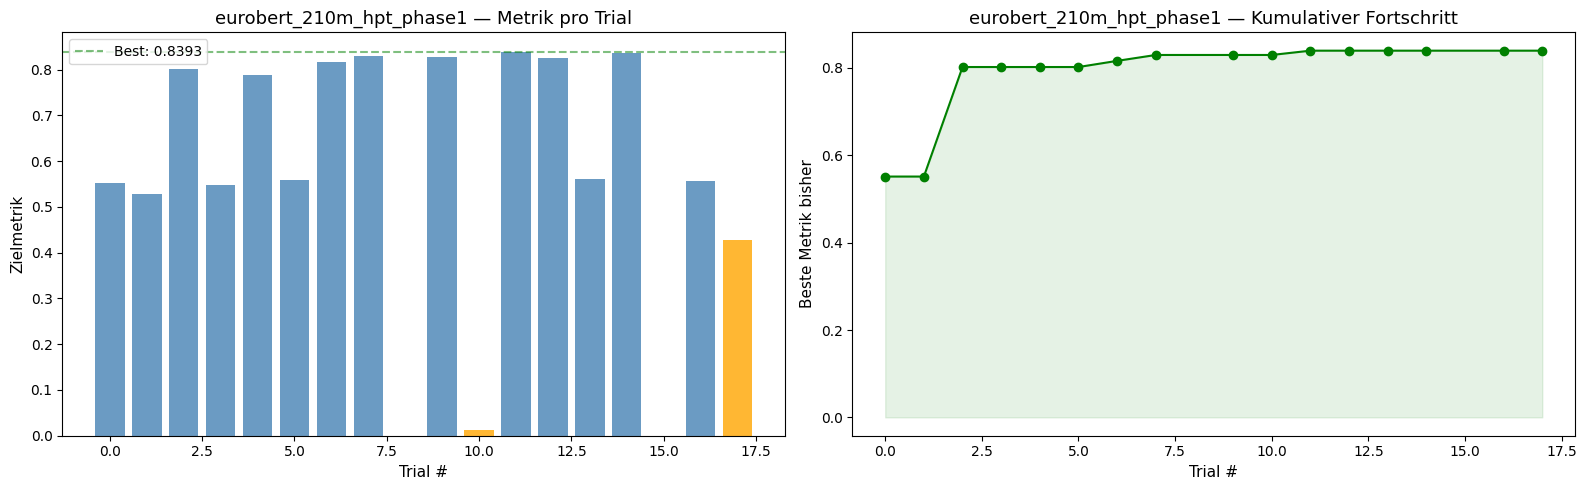

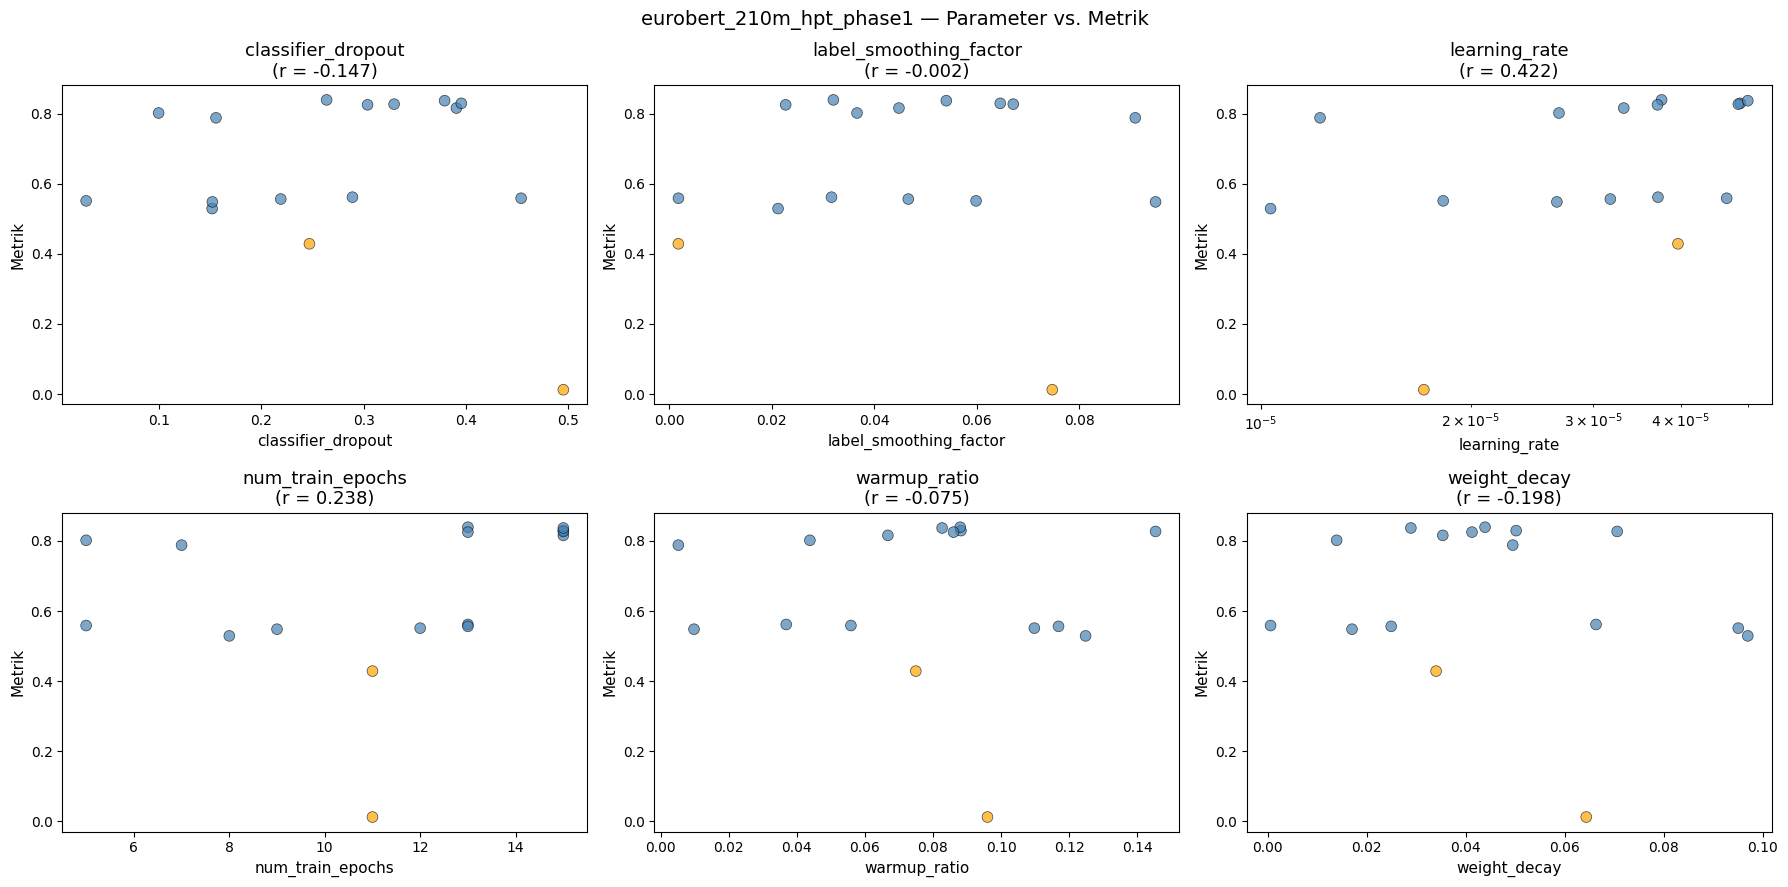

In [26]:
# ============================================================
# 7a. Metrik-Verlauf + Parameter Scatter Plots
# ============================================================

for entry in all_studies:
    name = entry["name"]
    raw = all_raw[name]
    df = raw["df"]
    param_names = raw["param_names"]
    param_distributions = raw["param_distributions"]
    ascending = raw["ascending"]

    # --- Metrik-Verlauf ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    has_value = df["value"].notna()
    ax = axes[0]
    colors = []
    for _, row in df[has_value].iterrows():
        if row["state"] == "PRUNED":
            colors.append("orange")
        elif row["value"] < 0.5:
            colors.append("red")
        else:
            colors.append("steelblue")

    ax.bar(df.loc[has_value, "number"], df.loc[has_value, "value"], color=colors, alpha=0.8)
    if has_value.any():
        best_val = df.loc[has_value, "value"].max() if not ascending else df.loc[has_value, "value"].min()
        ax.axhline(y=best_val, color="green", linestyle="--", alpha=0.5, label=f"Best: {best_val:.4f}")
    ax.set_xlabel("Trial #")
    ax.set_ylabel("Zielmetrik")
    ax.set_title(f"{name} — Metrik pro Trial")
    ax.legend()

    ax = axes[1]
    valid_sorted = df[has_value].sort_values("number")
    if len(valid_sorted) > 0:
        cum_best = valid_sorted["value"].cummin() if ascending else valid_sorted["value"].cummax()
        ax.plot(valid_sorted["number"], cum_best, "o-", color="green", markersize=6)
        ax.fill_between(valid_sorted["number"], cum_best, alpha=0.1, color="green")
    ax.set_xlabel("Trial #")
    ax.set_ylabel("Beste Metrik bisher")
    ax.set_title(f"{name} — Kumulativer Fortschritt")

    plt.tight_layout()
    plt.show()

    # --- Parameter vs. Metrik Scatter ---
    numeric_params = [p for p in param_names if param_distributions.get(p, {}).get("name") != "CategoricalDistribution"]
    if not numeric_params:
        continue

    plot_df = df[(df["value"].notna()) & (df["state"].isin(["COMPLETE", "PRUNED"]))].copy()
    if len(plot_df) < 3:
        continue

    n_params = len(numeric_params)
    ncols = min(3, n_params)
    nrows = (n_params + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4.5 * nrows))
    if n_params == 1:
        axes = np.array([axes])
    axes_flat = np.array(axes).flatten()

    for i, p in enumerate(numeric_params):
        ax = axes_flat[i]
        vals = pd.to_numeric(plot_df[p], errors="coerce")
        metrics = plot_df["value"]
        colors_scatter = ["orange" if s == "PRUNED" else "steelblue" for s in plot_df["state"]]
        ax.scatter(vals, metrics, c=colors_scatter, alpha=0.7, s=60, edgecolors="black", linewidths=0.5)

        valid_mask = vals.notna() & metrics.notna()
        if valid_mask.sum() > 2:
            corr = vals[valid_mask].corr(metrics[valid_mask])
            ax.set_title(f"{p}\n(r = {corr:.3f})")
        else:
            ax.set_title(p)

        ax.set_xlabel(p)
        ax.set_ylabel("Metrik")
        if param_distributions.get(p, {}).get("attributes", {}).get("log"):
            ax.set_xscale("log")

    for j in range(n_params, len(axes_flat)):
        axes_flat[j].set_visible(False)

    fig.suptitle(f"{name} — Parameter vs. Metrik", fontsize=14)
    plt.tight_layout()
    plt.show()

/var/folders/xp/7pdgws4n6_x1j904zf_1h06h0000gn/T/ipykernel_43110/2544220281.py:31: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/var/folders/xp/7pdgws4n6_x1j904zf_1h06h0000gn/T/ipykernel_43110/2544220281.py:31: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



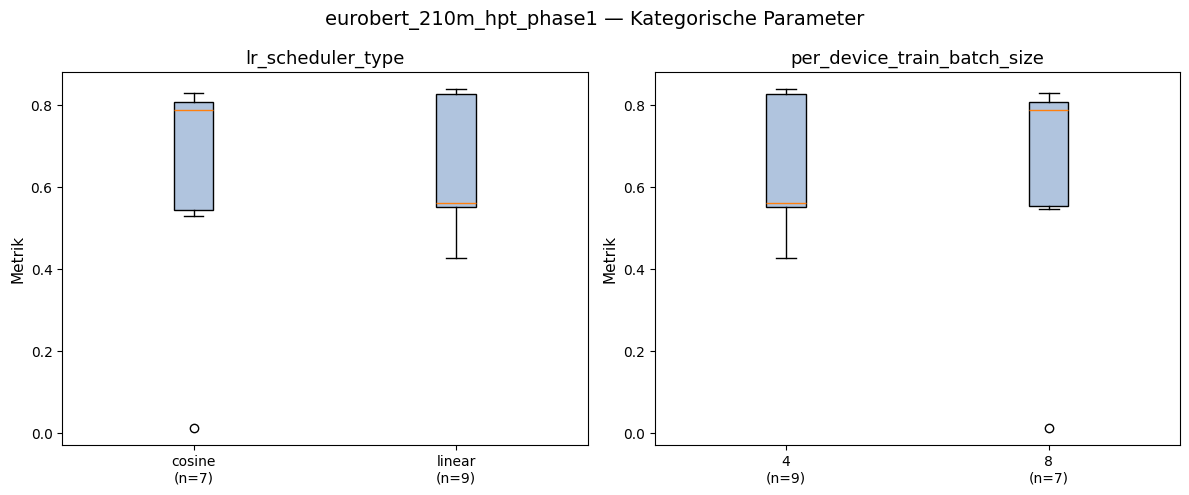

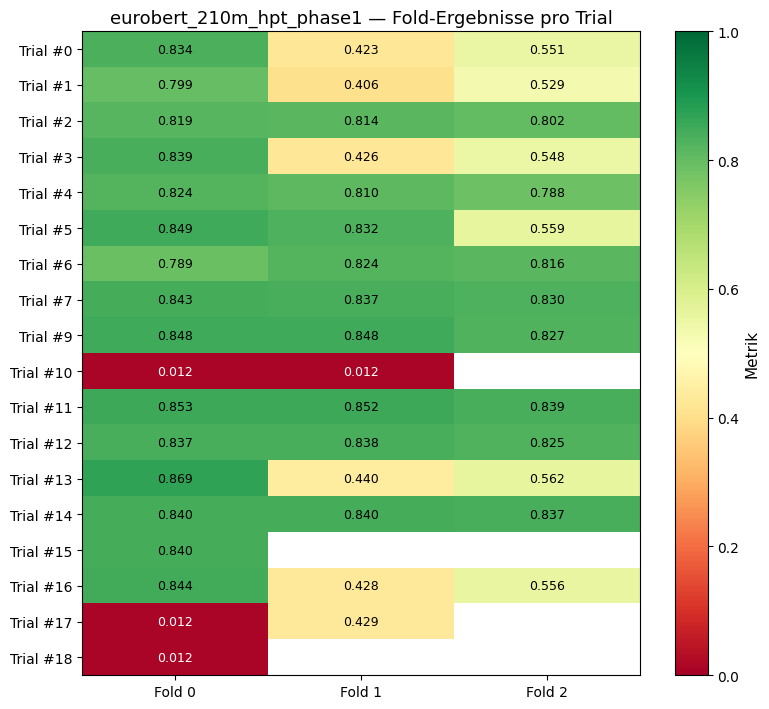

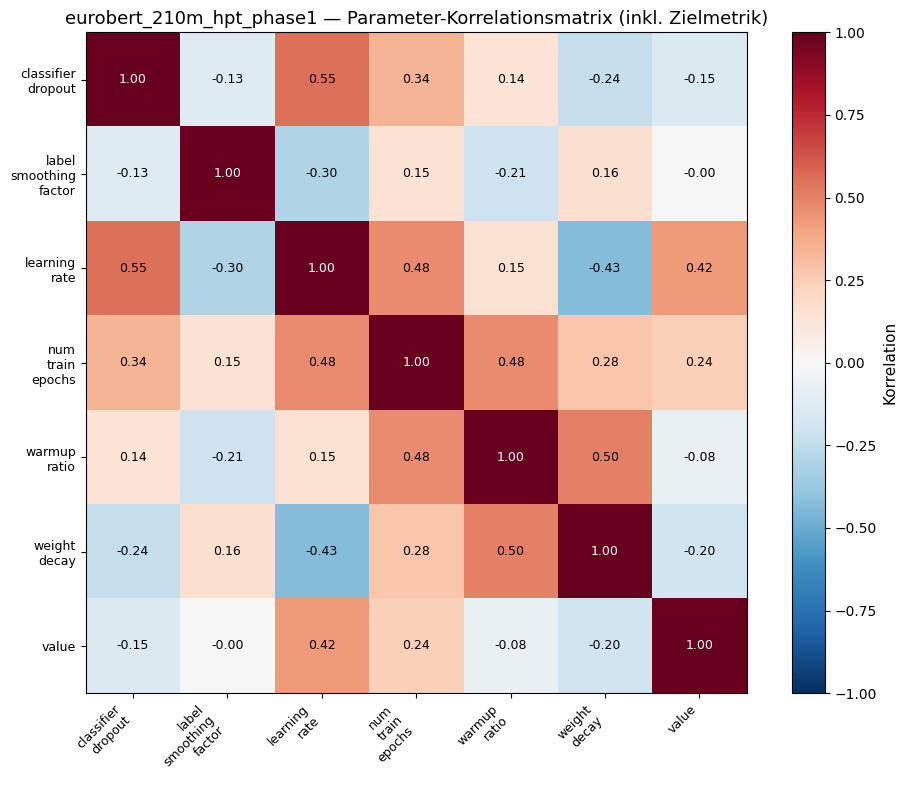

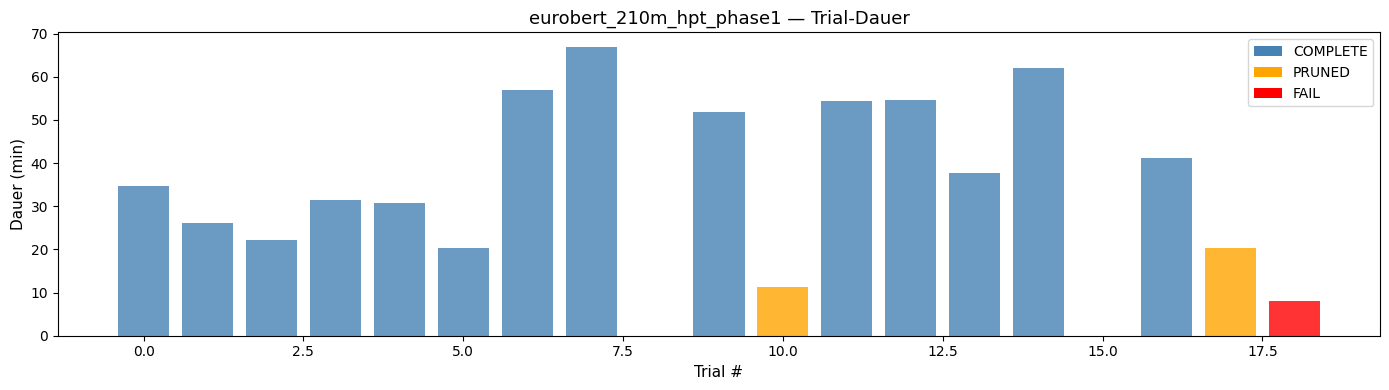

In [27]:
# ============================================================
# 7b. Kategorische Box-Plots, Fold-Heatmap, Dauer
# ============================================================

for entry in all_studies:
    name = entry["name"]
    raw = all_raw[name]
    df = raw["df"]
    param_names = raw["param_names"]
    param_distributions = raw["param_distributions"]
    intermediates = raw["intermediates"]

    plot_df = df[(df["value"].notna()) & (df["state"].isin(["COMPLETE", "PRUNED"]))].copy()

    # --- Kategorische Parameter Box-Plots ---
    cat_params = [p for p in param_names if param_distributions.get(p, {}).get("name") == "CategoricalDistribution"]
    if cat_params and len(plot_df) > 0:
        fig, axes = plt.subplots(1, len(cat_params), figsize=(6 * len(cat_params), 5))
        if len(cat_params) == 1:
            axes = [axes]

        for i, p in enumerate(cat_params):
            ax = axes[i]
            plot_data = plot_df[[p, "value"]].dropna()
            groups = plot_data.groupby(p)["value"]
            labels = []
            data = []
            for gname, group in groups:
                labels.append(f"{gname}\n(n={len(group)})")
                data.append(group.values)
            bp = ax.boxplot(data, labels=labels, patch_artist=True)
            for patch in bp["boxes"]:
                patch.set_facecolor("lightsteelblue")
            ax.set_title(p)
            ax.set_ylabel("Metrik")

        fig.suptitle(f"{name} — Kategorische Parameter", fontsize=14)
        plt.tight_layout()
        plt.show()

    # --- Fold-Heatmap ---
    if len(intermediates) > 0:
        pivot = intermediates.pivot(index="trial_id", columns="step", values="intermediate_value")
        trial_num_map = df.set_index("trial_id")["number"].to_dict()
        pivot.index = [f"Trial #{trial_num_map.get(tid, tid)}" for tid in pivot.index]
        pivot.columns = [f"Fold {c}" for c in pivot.columns]

        fig, ax = plt.subplots(figsize=(8, max(6, len(pivot) * 0.4)))
        im = ax.imshow(pivot.values, cmap="RdYlGn", aspect="auto", vmin=0, vmax=1)
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels(pivot.columns)
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index)

        for i in range(len(pivot.index)):
            for j in range(len(pivot.columns)):
                val = pivot.values[i, j]
                if not np.isnan(val):
                    color = "white" if val < 0.3 else "black"
                    ax.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=9, color=color)

        plt.colorbar(im, ax=ax, label="Metrik")
        ax.set_title(f"{name} — Fold-Ergebnisse pro Trial")
        plt.tight_layout()
        plt.show()

    # --- Parameter-Korrelationsmatrix ---
    numeric_params = [p for p in param_names if param_distributions.get(p, {}).get("name") != "CategoricalDistribution"]
    if len(numeric_params) > 1 and len(plot_df) > 3:
        corr_cols = numeric_params + ["value"]
        corr_data = plot_df[corr_cols].apply(pd.to_numeric, errors="coerce").dropna()
        if len(corr_data) > 3:
            corr_matrix = corr_data.corr()
            fig, ax = plt.subplots(figsize=(10, 8))
            im = ax.imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1)
            labels = [c.replace("_", "\n") for c in corr_matrix.columns]
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
            ax.set_yticks(range(len(labels)))
            ax.set_yticklabels(labels, fontsize=9)
            for i in range(len(corr_matrix)):
                for j in range(len(corr_matrix)):
                    val = corr_matrix.values[i, j]
                    color = "white" if abs(val) > 0.6 else "black"
                    ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9, color=color)
            plt.colorbar(im, ax=ax, label="Korrelation")
            ax.set_title(f"{name} — Parameter-Korrelationsmatrix (inkl. Zielmetrik)")
            plt.tight_layout()
            plt.show()

    # --- Dauer pro Trial ---
    dur_df = df[df["duration_min"].notna()].copy()
    if len(dur_df) > 0:
        fig, ax = plt.subplots(figsize=(14, 4))
        colors = []
        for _, row in dur_df.iterrows():
            if row["state"] == "FAIL":
                colors.append("red")
            elif row["state"] == "PRUNED":
                colors.append("orange")
            else:
                colors.append("steelblue")

        ax.bar(dur_df["number"], dur_df["duration_min"], color=colors, alpha=0.8)
        ax.set_xlabel("Trial #")
        ax.set_ylabel("Dauer (min)")
        ax.set_title(f"{name} — Trial-Dauer")
        ax.legend(handles=[
            Patch(facecolor="steelblue", label="COMPLETE"),
            Patch(facecolor="orange", label="PRUNED"),
            Patch(facecolor="red", label="FAIL"),
        ])
        plt.tight_layout()
        plt.show()

---
## 8. Empfohlene Phase-2-Suchbereiche

In [28]:
# ============================================================
# 8. VORGESCHLAGENE PHASE-2-SUCHBEREICHE
# ============================================================

for entry in all_studies:
    name = entry["name"]
    raw = all_raw[name]
    df = raw["df"]
    param_names = raw["param_names"]
    param_distributions = raw["param_distributions"]
    ascending = raw["ascending"]

    completed = df[df["state"] == "COMPLETE"].sort_values("value", ascending=ascending)
    top_n = completed.head(TOP_N)

    if len(top_n) == 0:
        print(f"  {name}: Keine COMPLETE Trials fuer Phase-2-Empfehlung.")
        continue

    print(f"\n{'=' * 70}")
    print(f"  {name} — PHASE-2-SUCHBEREICHE (basierend auf Top {TOP_N})")
    print(f"{'=' * 70}\n")

    for p in param_names:
        vals = top_n[p]
        dist = param_distributions.get(p, {})
        dist_name = dist.get("name", "")
        attrs = dist.get("attributes", {})

        if dist_name == "CategoricalDistribution":
            unique = vals.unique().tolist()
            print(f'  "{p}": {unique},')
        elif dist_name == "IntDistribution":
            numeric = pd.to_numeric(vals, errors="coerce")
            lo = int(numeric.min())
            hi = int(numeric.max())
            spread = hi - lo
            buffer = max(1, int(spread * 0.2))
            orig_lo = attrs.get("low", lo)
            orig_hi = attrs.get("high", hi)
            suggested_lo = max(orig_lo, lo - buffer)
            suggested_hi = min(orig_hi, hi + buffer)
            print(f'  "{p}": ({suggested_lo}, {suggested_hi}),')
        else:
            numeric = pd.to_numeric(vals, errors="coerce")
            lo = numeric.min()
            hi = numeric.max()
            spread = hi - lo
            buffer = spread * 0.2
            orig_lo = attrs.get("low", lo)
            orig_hi = attrs.get("high", hi)
            suggested_lo = max(orig_lo, lo - buffer)
            suggested_hi = min(orig_hi, hi + buffer)
            if attrs.get("log"):
                print(f'  "{p}": ({suggested_lo:.2e}, {suggested_hi:.2e}),  # log scale')
            else:
                print(f'  "{p}": ({suggested_lo:.4f}, {suggested_hi:.4f}),')


  eurobert_210m_hpt_phase1 — PHASE-2-SUCHBEREICHE (basierend auf Top 5)

  "classifier_dropout": (0.2376, 0.4217),
  "label_smoothing_factor": (0.0138, 0.0760),
  "learning_rate": (3.45e-05, 5.00e-05),  # log scale
  "lr_scheduler_type": ['linear', 'cosine'],
  "num_train_epochs": (12, 15),
  "per_device_train_batch_size": [4, 8],
  "warmup_ratio": (0.0702, 0.1500),
  "weight_decay": (0.0206, 0.0789),
